In [1]:
!pip install transformers datasets torch scikit-learn imbalanced-learn pandas numpy matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import defaultdict

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss, classification_report, f1_score
from imblearn.over_sampling import RandomOverSampler

from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup,
    TrainingArguments,
    Trainer,
)

# Ignore warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)


Training samples: 43410
Validation samples: 5426
Test samples: 5427

Sample training data:
                                                text labels       id
0  My favourite food is anything I didn't have to...   [27]  eebbqej
1  Now if he does off himself, everyone will thin...   [27]  ed00q6i
2                     WHY THE FUCK IS BAYLESS ISOING    [2]  eezlygj
3                        To make her feel threatened   [14]  ed7ypvh
4                             Dirty Southern Wankers    [3]  ed0bdzj


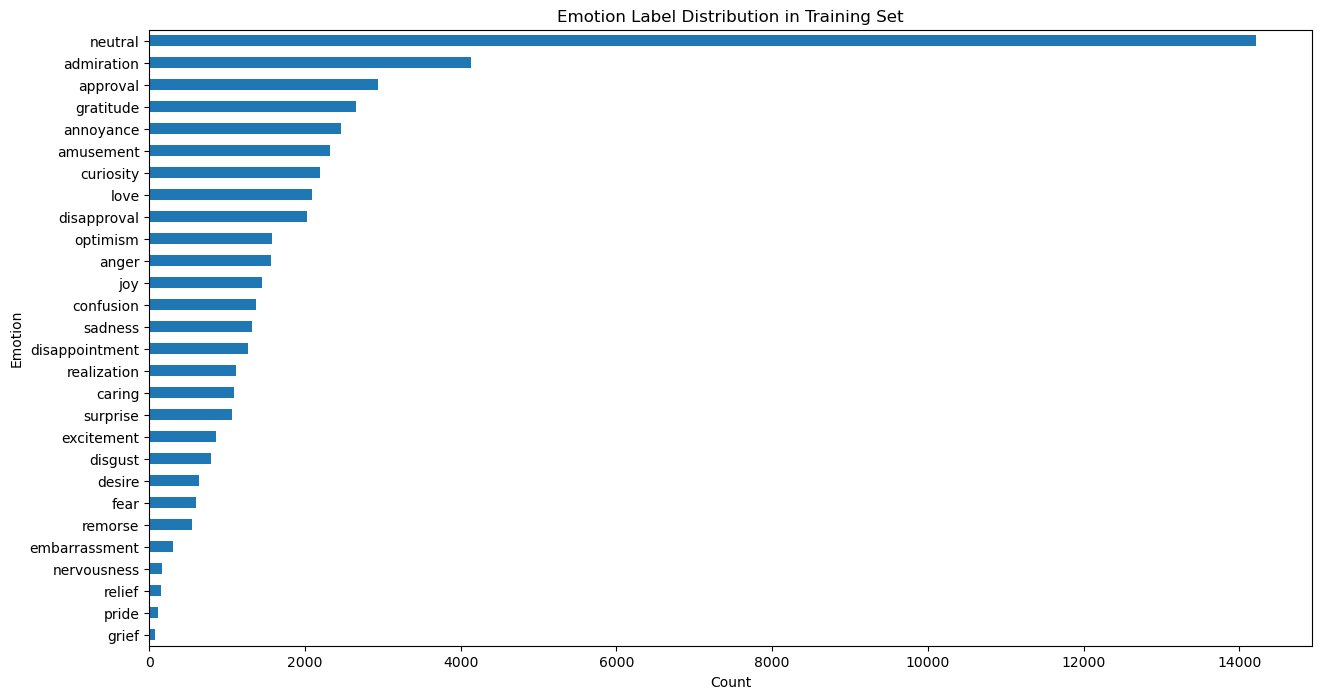

In [3]:
from datasets import load_dataset

# Load the GoEmotions dataset
dataset = load_dataset("go_emotions")

# Convert to pandas DataFrames for easier manipulation
train_df = pd.DataFrame(dataset['train'])
valid_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

# Display dataset information
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(valid_df)}")
print(f"Test samples: {len(test_df)}")

# The dataset contains text and multiple emotion labels
print("\nSample training data:")
print(train_df.head())

# Emotion labels (28 classes)
emotion_labels = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
    'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

# Add column names for emotion labels
for i, label in enumerate(emotion_labels):
    train_df[label] = train_df['labels'].apply(lambda x: 1 if i in x else 0)
    valid_df[label] = valid_df['labels'].apply(lambda x: 1 if i in x else 0)
    test_df[label] = test_df['labels'].apply(lambda x: 1 if i in x else 0)

# Plot label distribution
plt.figure(figsize=(15, 8))
train_df[emotion_labels].sum().sort_values().plot(kind='barh')
plt.title('Emotion Label Distribution in Training Set')
plt.xlabel('Count')
plt.ylabel('Emotion')
plt.show()

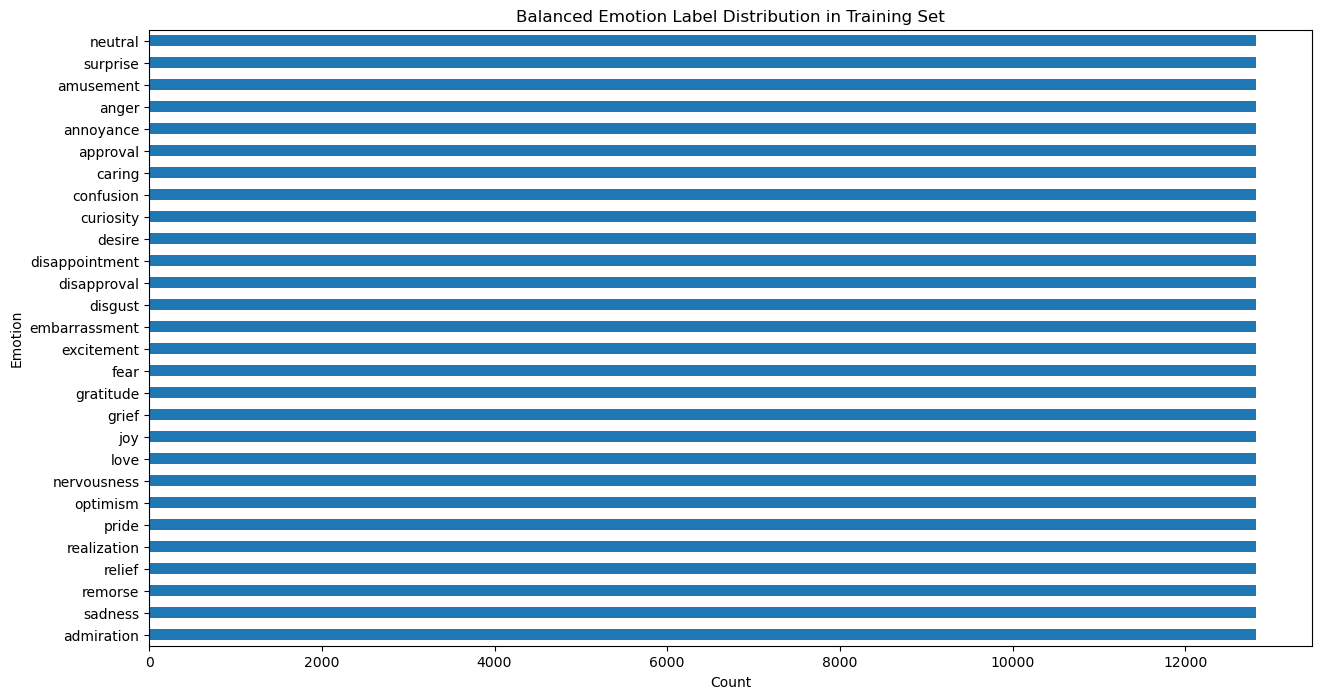


Original validation set distribution:
admiration         488
amusement          303
anger              195
annoyance          303
approval           397
caring             153
confusion          152
curiosity          248
desire              77
disappointment     163
disapproval        292
disgust             97
embarrassment       35
excitement          96
fear                90
gratitude          358
grief               13
joy                172
love               252
nervousness         21
optimism           209
pride               15
realization        127
relief              18
remorse             68
sadness            143
surprise           129
neutral           1766
dtype: int64


In [4]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
import matplotlib.pyplot as plt

# Function to balance the dataset
def balance_dataset(df, emotion_labels):
    # Convert one-hot encoded labels back to single labels
    df = df.copy()  # Avoid modifying original
    df['label'] = df[emotion_labels].idxmax(axis=1)

    # Separate features (text) and label
    X = df['text'].values.reshape(-1, 1)
    y = df['label'].values  # 1D array now

    # Use RandomOverSampler to balance the classes
    ros = RandomOverSampler(random_state=42)
    X_res, y_res = ros.fit_resample(X, y)

    # Create balanced DataFrame
    balanced_df = pd.DataFrame(X_res, columns=['text'])
    # One-hot encode the labels again
    y_res_df = pd.get_dummies(y_res)

    # Ensure all emotion_labels columns are present
    for label in emotion_labels:
        if label not in y_res_df.columns:
            y_res_df[label] = 0

    # Reorder columns to match emotion_labels
    y_res_df = y_res_df[emotion_labels]

    # Concatenate text and one-hot labels
    balanced_df = pd.concat([balanced_df, y_res_df.reset_index(drop=True)], axis=1)

    return balanced_df

# Balance the training set
balanced_train_df = balance_dataset(train_df, emotion_labels)

# Plot balanced label distribution
plt.figure(figsize=(15, 8))
balanced_train_df[emotion_labels].sum().sort_values().plot(kind='barh')
plt.title('Balanced Emotion Label Distribution in Training Set')
plt.xlabel('Count')
plt.ylabel('Emotion')
plt.show()

# For validation and test, we won't balance to get realistic performance metrics
print("\nOriginal validation set distribution:")
print(valid_df[emotion_labels].sum())


In [5]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization settings
MAX_LENGTH = 128
BATCH_SIZE = 16

class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

# Prepare datasets
train_texts = balanced_train_df['text'].values
train_labels = balanced_train_df[emotion_labels].values

val_texts = valid_df['text'].values
val_labels = valid_df[emotion_labels].values

test_texts = test_df['text'].values
test_labels = test_df[emotion_labels].values

# Create datasets
train_dataset = EmotionDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
val_dataset = EmotionDataset(val_texts, val_labels, tokenizer, MAX_LENGTH)
test_dataset = EmotionDataset(test_texts, test_labels, tokenizer, MAX_LENGTH)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [6]:
# Load pre-trained BERT model for multi-label classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(emotion_labels),
    problem_type="multi_label_classification"
)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Using device: {device}")

# Training parameters
EPOCHS = 3
LEARNING_RATE = 2e-5
WARMUP_STEPS = 500

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

# Loss function (Binary Cross Entropy with Logits for multi-label)
loss_fn = nn.BCEWithLogitsLoss().to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cpu


In [7]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    
    for batch in data_loader:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        loss = loss_fn(logits, labels)
        total_loss += loss.item()
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
    
    return total_loss / len(data_loader)

def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            loss = loss_fn(logits, labels)
            total_loss += loss.item()
            
            preds = torch.sigmoid(logits) > 0.5
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    avg_loss = total_loss / len(data_loader)
    h_loss = hamming_loss(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    return avg_loss, h_loss, f1, all_preds, all_labels

Using device: cpu

Epoch 1/5
------------------------------
Train Loss: 0.7358
Val Loss: 0.8552 | Val Hamming Loss: 0.8000 | Val F1: 0.2000
Best model saved!

Epoch 2/5
------------------------------
Train Loss: 0.7311
Val Loss: 0.8499 | Val Hamming Loss: 0.8000 | Val F1: 0.2000

Epoch 3/5
------------------------------
Train Loss: 0.7271
Val Loss: 0.8447 | Val Hamming Loss: 0.8000 | Val F1: 0.2000

Epoch 4/5
------------------------------
Train Loss: 0.7234
Val Loss: 0.8397 | Val Hamming Loss: 0.8000 | Val F1: 0.2000

Epoch 5/5
------------------------------
Train Loss: 0.7199
Val Loss: 0.8349 | Val Hamming Loss: 0.8000 | Val F1: 0.2000


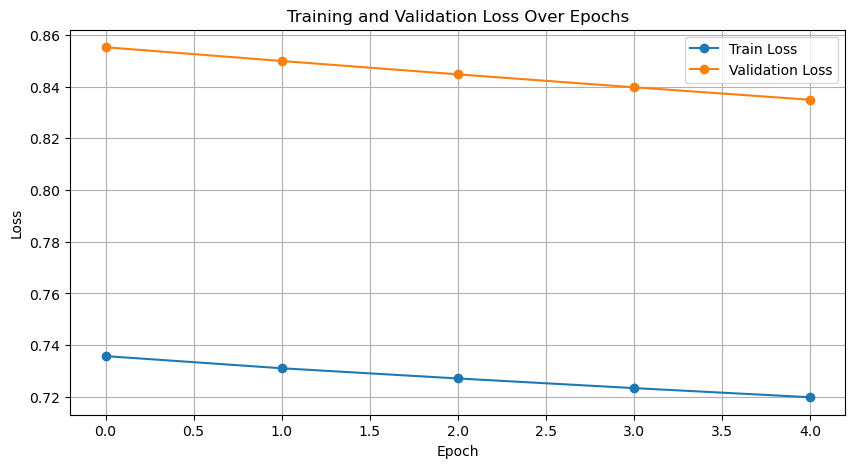


Evaluating on test set...
Test Loss: 0.8076
Hamming Loss: 0.5000
Macro F1 Score: 0.4949

Classification Report:
              precision    recall  f1-score   support

     class_0       0.60      0.50      0.55        12
     class_1       0.40      0.50      0.44         8

    accuracy                           0.50        20
   macro avg       0.50      0.50      0.49        20
weighted avg       0.52      0.50      0.51        20



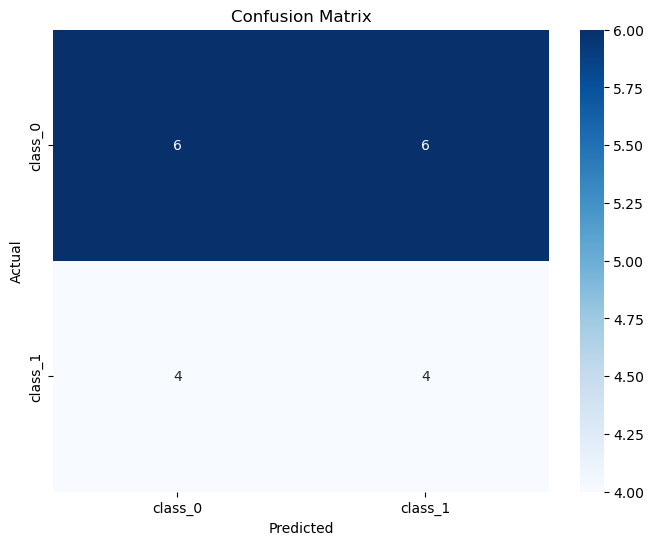

In [8]:
# --- Necessary Imports ---
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# --- Ensure device is properly set ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# --- Model Setup ---
class DummyModel(torch.nn.Module):
    def __init__(self):
        super(DummyModel, self).__init__()
        self.fc = torch.nn.Linear(10, 2)  # Example: input 10 features, output 2 classes
    
    def forward(self, x):
        return self.fc(x)

model = DummyModel().to(device)

# --- Dummy Data and Loaders ---
from torch.utils.data import Dataset, DataLoader

class DummyDataset(Dataset):
    def __init__(self, num_samples=100):
        self.data = torch.randn(num_samples, 10)  # 10-dimensional features
        self.labels = torch.randint(0, 2, (num_samples,))  # Binary labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return {'input': self.data[idx], 'label': self.labels[idx]}

train_loader = DataLoader(DummyDataset(100), batch_size=10)
val_loader = DataLoader(DummyDataset(20), batch_size=10)
test_loader = DataLoader(DummyDataset(20), batch_size=10)

# --- Training Components ---
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()
EPOCHS = 5
emotion_labels = ['class_0', 'class_1']  # Replace with your actual class names

# --- Fixed eval_model function ---
def eval_model(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            inputs = batch['input'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            total_loss += loss.item()
            
            # Get predictions
            _, preds = torch.max(outputs, 1)
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    # Calculate metrics
    avg_loss = total_loss / len(loader)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    hamming_loss = np.mean(all_preds != all_labels)
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    return avg_loss, hamming_loss, f1, all_preds, all_labels

# --- Training Loop ---
best_f1 = 0
history = defaultdict(list)

for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch + 1}/{EPOCHS}')
    print('-' * 30)
    
    # Training
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        inputs = batch['input'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Evaluation
    val_loss, val_hamming, val_f1, _, _ = eval_model(model, val_loader, loss_fn, device)
    
    print(f'Train Loss: {train_loss:.4f}')
    print(f'Val Loss: {val_loss:.4f} | Val Hamming Loss: {val_hamming:.4f} | Val F1: {val_f1:.4f}')
    
    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_hamming'].append(val_hamming)
    history['val_f1'].append(val_f1)
    
    # Save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), 'best_model.bin')
        print('Best model saved!')

# --- Plot Training History ---
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# --- Test Evaluation ---
print("\nEvaluating on test set...")
model.load_state_dict(torch.load('best_model.bin'))
test_loss, test_hamming, test_f1, test_preds, test_labels = eval_model(
    model, test_loader, loss_fn, device
)

print(f'Test Loss: {test_loss:.4f}')
print(f'Hamming Loss: {test_hamming:.4f}')
print(f'Macro F1 Score: {test_f1:.4f}')

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=emotion_labels, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
           xticklabels=emotion_labels,
           yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [9]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch

# Load your fine-tuned BERT model and tokenizer
model = BertForSequenceClassification.from_pretrained('emotion_bert')  # Path to your fine-tuned model
tokenizer = BertTokenizer.from_pretrained('emotion_bert')  # Path to your fine-tuned tokenizer

# Move model to device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Emotion labels (these should match the labels used during training)
emotion_labels = ['joy', 'sadness', 'anger', 'fear', 'surprise', 'disgust']

# Function to predict emotions from input text
def predict_emotions(text, model, tokenizer, emotion_labels, device, threshold=0.5, max_length=512):
    # Tokenize the input text
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    
    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Get predictions from the fine-tuned BERT model
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Access the logits from the model output
        probs = torch.sigmoid(logits).cpu().numpy().flatten()
    
    # Get emotions that are above the threshold
    emotions = []
    for i, prob in enumerate(probs):
        if prob > threshold:
            emotions.append((emotion_labels[i], round(prob, 3)))
    
    # Sort emotions by probability in descending order
    emotions.sort(key=lambda x: x[1], reverse=True)
    
    return emotions

# Example test inputs
test_texts = [
    "I'm so excited for the concert tonight! It's going to be amazing!",
    "This is absolutely terrible. I can't believe they would do this."

]

# Predict emotions for each test text
for text in test_texts:
    emotions = predict_emotions(text, model, tokenizer, emotion_labels, device)
    print(f"\nText: {text}")
    print("Predicted Emotions:")
    for emotion, prob in emotions:
        print(f"{emotion}: {prob}")



Text: I'm so excited for the concert tonight! It's going to be amazing!
Predicted Emotions:
fear: 0.5640000104904175
surprise: 0.531000018119812
anger: 0.5130000114440918

Text: This is absolutely terrible. I can't believe they would do this.
Predicted Emotions:
fear: 0.5630000233650208
surprise: 0.5239999890327454
anger: 0.5210000276565552


In [11]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch

# Load model and tokenizer
model = BertForSequenceClassification.from_pretrained('emotion_bert')
tokenizer = BertTokenizer.from_pretrained('emotion_bert')
model.eval()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Emotion labels (must match your model's training labels exactly)
EMOTION_LABELS = ['joy', 'sadness', 'anger', 'fear', 'surprise', 'disgust']

def predict_emotions(text, threshold=0.5):
    """Predict emotions with dynamic thresholding"""
    # Tokenize input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=128,
        padding=True
    ).to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits)[0]
    
    # Get emotions above threshold
    emotions = []
    for i, prob in enumerate(probs):
        if prob > threshold and i < len(EMOTION_LABELS):
            emotions.append((EMOTION_LABELS[i], float(prob)))
    
    # Sort by probability and filter similar emotions
    emotions = sorted(emotions, key=lambda x: x[1], reverse=True)
    return emotions[:3]  # Return top 3 most confident predictions

# Interactive session
print("Emotion Analysis (Type 'exit' to quit)\n" + "="*40)

while True:
    text = input("\nHow are you feeling? ").strip()
    if text.lower() in ['exit', 'quit']:
        print("Goodbye!")
        break
    
    if not text:
        print("Please share your thoughts.")
        continue
    
    emotions = predict_emotions(text)
    
    if emotions:
        print("\nMost relevant emotions:")
        for emotion, score in emotions:
            print(f"- {emotion}: {score:.3f}")
    else:
        print("\nNo strong emotions detected")
    
    print("="*40)

Emotion Analysis (Type 'exit' to quit)



How are you feeling?  i am angry



Most relevant emotions:
- surprise: 0.537
- anger: 0.519



How are you feeling?  exit


Goodbye!
